# Nokappa v3 Pipeline: Constant vs Cos300

Both configs use **non-centered parameterization** with **kappa=1 (fixed)**, W=1e-4, 300 epochs.  
- **Constant**: LR=0.1 constant  
- **Cos300**: LR=0.1 → 0.001 cosine annealing  

**Pipeline steps:**
1. Load and pool params from 10 training batches per config
2. Diagnostic summary: gamma magnitude, top G features, psi switches
3. LOO prediction (5 batches = 50k patients)
4. AUC + calibration comparison

In [ ]:
import numpy as np
import pandas as pd
import torch
import glob
import os
import sys
import time
import gc
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.insert(0, str(Path(__file__).parent) if '__file__' in dir() else str(Path.cwd() / 'claudefile'))
from nokappa_prediction_utils import fit_and_extract_pi  # shared: no NaN in pi

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Paths
DATA_DIR = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'
CONST_DIR = '/Users/sarahurbut/Library/CloudStorage/Dropbox/nokappa_v3_W1e-4/'
COS_DIR = '/Users/sarahurbut/Library/CloudStorage/Dropbox/nokappa_v3_cos300/'
OUTPUT_BASE = '/Users/sarahurbut/Library/CloudStorage/Dropbox/'
COV_PATH = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv'
PCE_PATH = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv'

# PRS feature names (36 PRS + sex + 10 PCs = 47 total)
prs_df = pd.read_csv('/Users/sarahurbut/aladynoulli2/prs_names.csv')
PRS_NAMES = list(prs_df.columns) + list(prs_df.iloc[:, 0].values)
FEATURE_NAMES = PRS_NAMES + ['Sex'] + [f'PC{i}' for i in range(1, 11)]
print(f'{len(PRS_NAMES)} PRS features + Sex + 10 PCs = {len(FEATURE_NAMES)} total features')

N_BATCHES = 10
BATCH_SIZE = 10000
N_PRED_BATCHES = 5

36 PRS features + Sex + 10 PCs = 47 total features


## 1. Load and Pool Parameters

In [ ]:
def load_all_checkpoints(ckpt_dir, pattern):
    """Load phi, psi, kappa, gamma from all batch checkpoints."""
    files = sorted(glob.glob(os.path.join(ckpt_dir, pattern)))
    print(f'Found {len(files)} files in {ckpt_dir}')
    
    all_phi, all_psi, all_kappa, all_gamma = [], [], [], []
    batch_stats = []
    
    for fp in files:
        ckpt = torch.load(fp, weights_only=False)
        
        def _get(name):
            if 'model_state_dict' in ckpt and name in ckpt['model_state_dict']:
                return ckpt['model_state_dict'][name]
            return ckpt.get(name)
        
        phi = _get('phi')
        psi = _get('psi')
        gamma = _get('gamma')
        kappa = _get('kappa')
        
        if phi is None or gamma is None:
            print(f'  Skip {Path(fp).name}: missing phi or gamma')
            continue
        
        phi_np = phi.detach().cpu().numpy() if torch.is_tensor(phi) else np.array(phi)
        psi_np = psi.detach().cpu().numpy() if torch.is_tensor(psi) else np.array(psi) if psi is not None else None
        gamma_np = gamma.detach().cpu().numpy() if torch.is_tensor(gamma) else np.array(gamma)
        k = kappa.item() if torch.is_tensor(kappa) else float(kappa) if kappa is not None else 1.0
        
        all_phi.append(phi_np)
        all_psi.append(psi_np)
        all_kappa.append(k)
        all_gamma.append(gamma_np)
        
        batch_stats.append({
            'file': Path(fp).name,
            'mean_abs_gamma': np.abs(gamma_np).mean(),
            'kappa': k,
        })
    
    print(f'Loaded {len(all_phi)} checkpoints')
    return all_phi, all_psi, all_kappa, all_gamma, pd.DataFrame(batch_stats)

# Load constant
print('=== CONSTANT (LR=0.1 constant, 300ep) ===')
const_phi, const_psi, const_kappa, const_gamma, const_stats = \
    load_all_checkpoints(CONST_DIR, 'enrollment_model_REPARAM_NOKAPPA_W0.0001_batch_*_*.pt')

print('\n=== COS300 (LR=0.1→0.001 cosine, 300ep) ===')
cos_phi, cos_psi, cos_kappa, cos_gamma, cos_stats = \
    load_all_checkpoints(COS_DIR, 'enrollment_model_REPARAM_NOKAPPA_COS300_W0.0001_batch_*_*.pt')

=== CONSTANT (LR=0.1 constant, 300ep) ===
Found 10 files in /Users/sarahurbut/Library/CloudStorage/Dropbox/nokappa_v3_W1e-4/
Loaded 10 checkpoints

=== COS300 (LR=0.1→0.001 cosine, 300ep) ===
Found 10 files in /Users/sarahurbut/Library/CloudStorage/Dropbox/nokappa_v3_cos300/
Loaded 10 checkpoints


In [ ]:
# Pool parameters (full pool, no LOO exclusion)
def pool_params(all_phi, all_psi, all_kappa, all_gamma):
    phi = np.mean(np.stack(all_phi), axis=0)
    kappa = float(np.mean(all_kappa))
    gamma = np.mean(np.stack(all_gamma), axis=0)
    psi_valid = [p for p in all_psi if p is not None]
    psi = np.mean(np.stack(psi_valid), axis=0) if psi_valid else None
    return phi, psi, kappa, gamma

phi_const, psi_const, kappa_const, gamma_const = pool_params(const_phi, const_psi, const_kappa, const_gamma)
phi_cos, psi_cos, kappa_cos, gamma_cos = pool_params(cos_phi, cos_psi, cos_kappa, cos_gamma)

print(f'CONSTANT pooled: phi {phi_const.shape}, psi {psi_const.shape}, kappa={kappa_const:.4f}, gamma {gamma_const.shape}')
print(f'  mean|gamma| = {np.abs(gamma_const).mean():.4f}')
print(f'\nCOS300 pooled: phi {phi_cos.shape}, psi {psi_cos.shape}, kappa={kappa_cos:.4f}, gamma {gamma_cos.shape}')
print(f'  mean|gamma| = {np.abs(gamma_cos).mean():.4f}')

CONSTANT pooled: phi (21, 348, 52), psi (21, 348), kappa=1.0000, gamma (47, 21)
  mean|gamma| = 0.1166

COS300 pooled: phi (21, 348, 52), psi (21, 348), kappa=1.0000, gamma (47, 21)
  mean|gamma| = 0.1159


## 2. Diagnostic Summary

### 2a. Gamma magnitude per batch

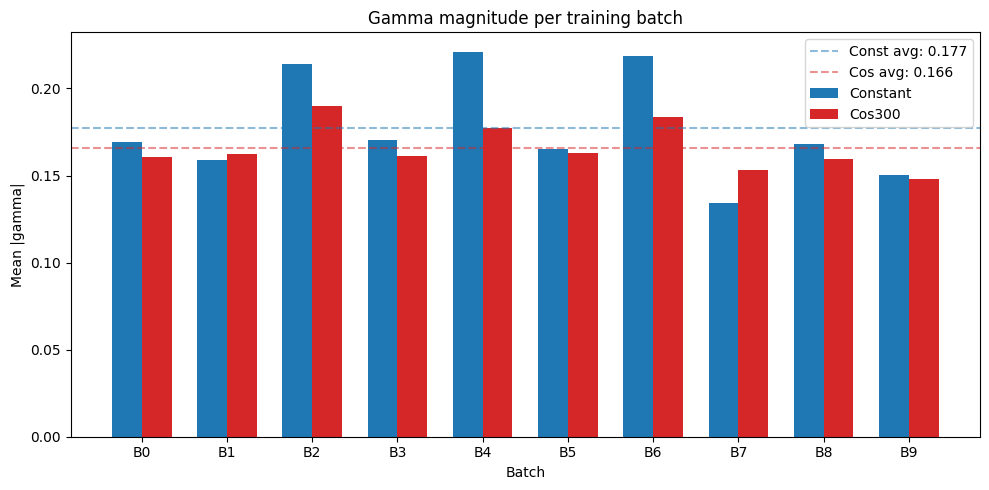

Constant: mean|gamma| = 0.1771 (range 0.1345 - 0.2212)
Cos300:   mean|gamma| = 0.1659 (range 0.1482 - 0.1899)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(const_stats))
w = 0.35
ax.bar(x - w/2, const_stats['mean_abs_gamma'], w, label='Constant', color='#1f77b4')
ax.bar(x + w/2, cos_stats['mean_abs_gamma'], w, label='Cos300', color='#d62728')
ax.set_xlabel('Batch')
ax.set_ylabel('Mean |gamma|')
ax.set_title('Gamma magnitude per training batch')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels([f'B{i}' for i in range(len(x))])

const_mean = const_stats['mean_abs_gamma'].mean()
cos_mean = cos_stats['mean_abs_gamma'].mean()
ax.axhline(const_mean, color='#1f77b4', ls='--', alpha=0.5, label=f'Const avg: {const_mean:.3f}')
ax.axhline(cos_mean, color='#d62728', ls='--', alpha=0.5, label=f'Cos avg: {cos_mean:.3f}')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Constant: mean|gamma| = {const_mean:.4f} (range {const_stats["mean_abs_gamma"].min():.4f} - {const_stats["mean_abs_gamma"].max():.4f})')
print(f'Cos300:   mean|gamma| = {cos_mean:.4f} (range {cos_stats["mean_abs_gamma"].min():.4f} - {cos_stats["mean_abs_gamma"].max():.4f})')

### 2b. Top G features (PRS/PC) per signature

In [ ]:
def top_features_per_sig(gamma_pooled, feature_names, n_top=5):
    """For each signature k, show top features by |gamma|."""
    P, K = gamma_pooled.shape
    rows = []
    for k in range(K):
        weights = gamma_pooled[:, k]
        order = np.argsort(-np.abs(weights))
        top_feats = []
        for idx in order[:n_top]:
            name = feature_names[idx] if idx < len(feature_names) else f'Feat{idx}'
            top_feats.append(f'{name} ({weights[idx]:+.3f})')
        rows.append({
            'sig': k,
            'mean_abs': np.abs(weights).mean(),
            'top_features': ', '.join(top_feats)
        })
    return pd.DataFrame(rows)

print('=== CONSTANT: Top 5 features per signature ===')
df_const_top = top_features_per_sig(gamma_const, FEATURE_NAMES)
for _, row in df_const_top.iterrows():
    print(f"  Sig {row['sig']:2d} (|g|={row['mean_abs']:.3f}): {row['top_features']}")

print(f'\n=== COS300: Top 5 features per signature ===')
df_cos_top = top_features_per_sig(gamma_cos, FEATURE_NAMES)
for _, row in df_cos_top.iterrows():
    print(f"  Sig {row['sig']:2d} (|g|={row['mean_abs']:.3f}): {row['top_features']}")

=== CONSTANT: Top 5 features per signature ===
  Sig  0 (|g|=0.085): Sex (+0.617), AF (+0.336), PC9 (+0.292), BMI (+0.184), PC3 (+0.171)
  Sig  1 (|g|=0.057): PC9 (+0.300), BMI (+0.207), ISS (+0.142), AST (+0.140), HT (+0.117)
  Sig  2 (|g|=0.063): PC9 (+0.324), Sex (+0.242), BMI (+0.140), ISS (+0.137), AST (+0.136)
  Sig  3 (|g|=0.066): Sex (+0.469), PC9 (+0.300), BMI (+0.151), VTE (+0.141), ISS (+0.127)
  Sig  4 (|g|=0.209): Sex (+2.335), PC1 (-1.364), AST (+0.630), PC5 (-0.504), T2D (-0.395)
  Sig  5 (|g|=0.083): Sex (+0.643), PC9 (+0.297), CAD (+0.254), HT (+0.199), CVD (+0.171)
  Sig  6 (|g|=0.230): PC1 (-4.708), Sex (-1.178), PC2 (+0.616), PC9 (+0.423), BC (+0.326)
  Sig  7 (|g|=0.065): PC9 (+0.277), HT (+0.215), Sex (+0.183), BMI (+0.178), AST (+0.163)
  Sig  8 (|g|=0.086): Sex (-1.626), PC9 (+0.241), PC1 (+0.138), BMI (+0.131), ISS (+0.126)
  Sig  9 (|g|=0.102): PC2 (+0.785), PC3 (+0.632), PC1 (-0.606), PC9 (+0.306), BMI (+0.204)
  Sig 10 (|g|=0.067): PC9 (+0.328), PC3 (+0.242)

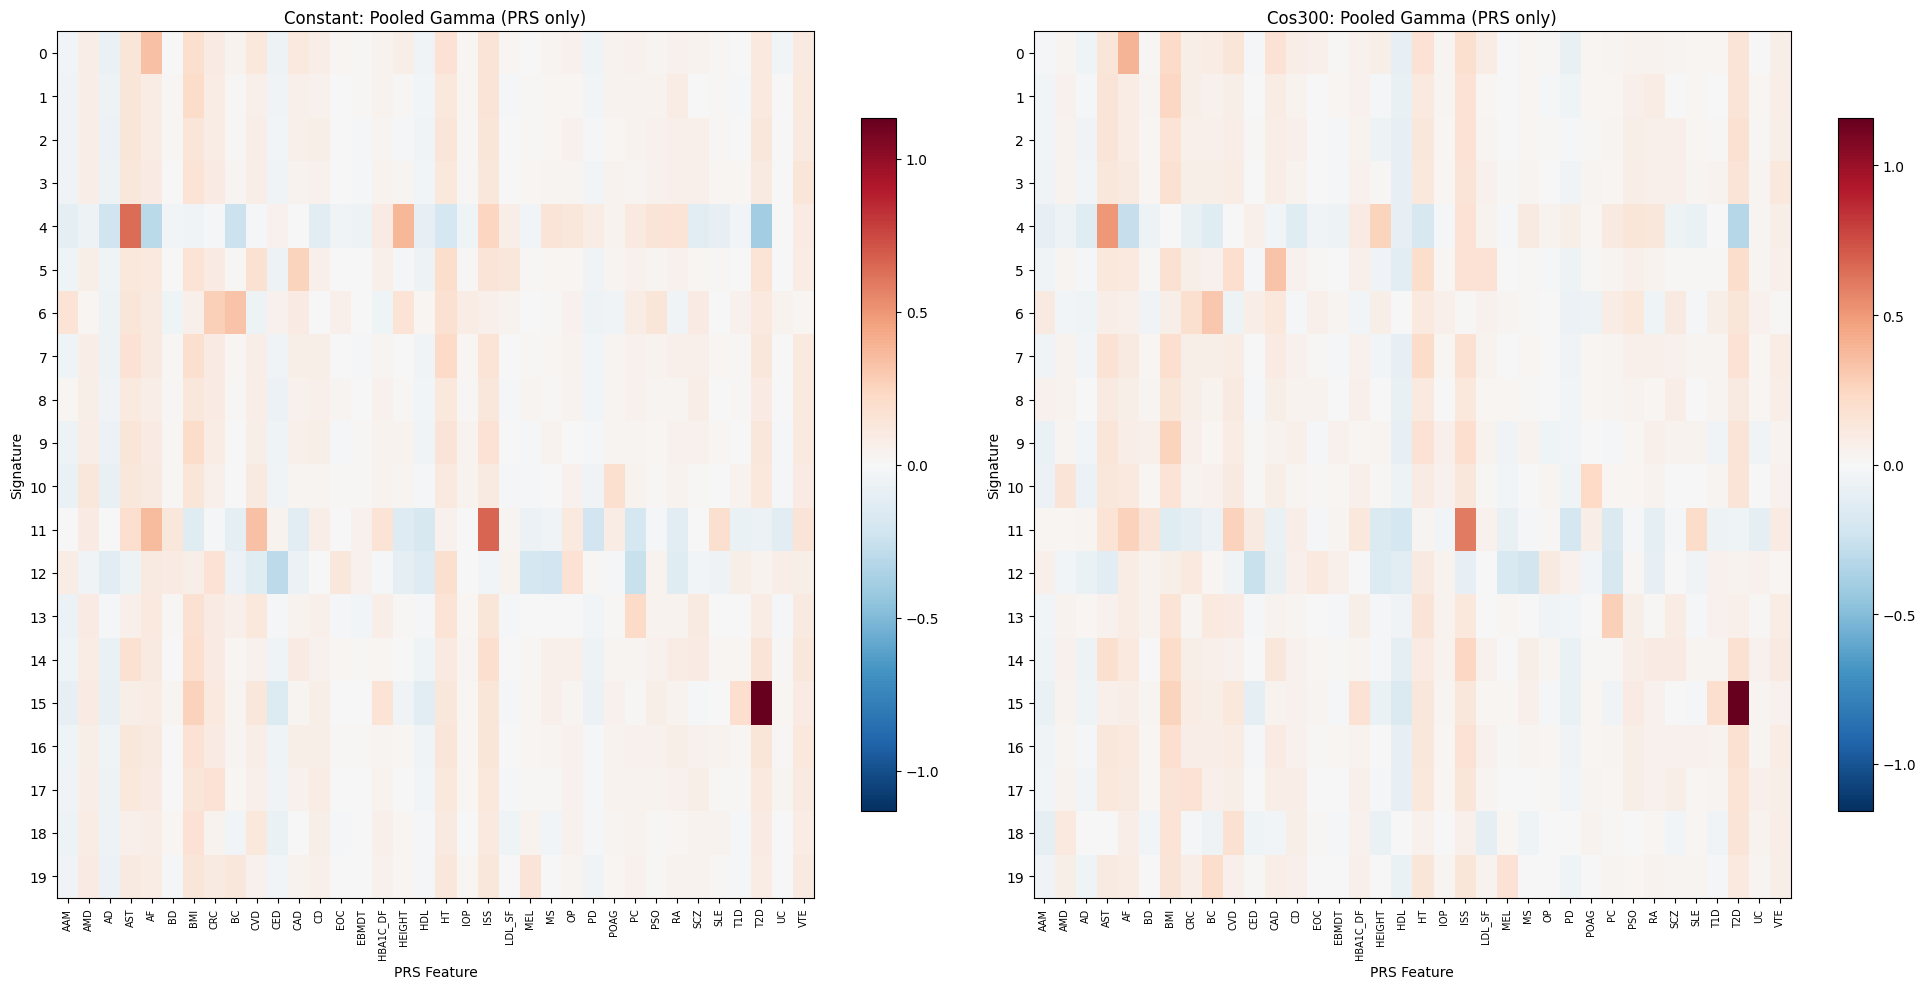

In [ ]:
# Heatmap: gamma (PRS only, first 36 features) for both configs
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
n_prs = 36  # PRS features only

for ax, gamma, title in [
    (axes[0], gamma_const[:n_prs, :20], 'Constant'),  # exclude healthy sig
    (axes[1], gamma_cos[:n_prs, :20], 'Cos300'),
]:
    im = ax.imshow(gamma.T, aspect='auto', cmap='RdBu_r',
                   vmin=-np.abs(gamma).max(), vmax=np.abs(gamma).max())
    ax.set_xlabel('PRS Feature')
    ax.set_ylabel('Signature')
    ax.set_title(f'{title}: Pooled Gamma (PRS only)')
    ax.set_xticks(range(n_prs))
    ax.set_xticklabels(PRS_NAMES, rotation=90, fontsize=7)
    ax.set_yticks(range(20))
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

### 2c. Psi switches between configs

In [ ]:
# Compare psi (soft assignments) between constant and cos300
# psi is (K_total, D) = (21, 348)
# Disease assignment = argmax(softmax(psi, dim=0))

psi_const_prob = torch.softmax(torch.tensor(psi_const), dim=0).numpy()  # (21, 348)
psi_cos_prob = torch.softmax(torch.tensor(psi_cos), dim=0).numpy()

assign_const = psi_const_prob[:20].argmax(axis=0)  # (348,) — exclude healthy row for assignment
assign_cos = psi_cos_prob[:20].argmax(axis=0)

n_switches = (assign_const != assign_cos).sum()
n_total = len(assign_const)

print(f'Psi assignment switches between Constant and Cos300:')
print(f'  {n_switches}/{n_total} diseases switched signature ({100*n_switches/n_total:.1f}%)')

# Also compute per-batch psi switches
print(f'\nPer-batch psi switches within each config:')
for name, all_psi in [('Constant', const_psi), ('Cos300', cos_psi)]:
    switches = []
    for i in range(1, len(all_psi)):
        if all_psi[i-1] is not None and all_psi[i] is not None:
            a1 = torch.softmax(torch.tensor(all_psi[i-1][:20]), dim=0).numpy().argmax(axis=0)
            a2 = torch.softmax(torch.tensor(all_psi[i][:20]), dim=0).numpy().argmax(axis=0)
            switches.append((a1 != a2).sum())
    mean_sw = np.mean(switches) if switches else 0
    print(f'  {name}: avg {mean_sw:.1f} switches between consecutive batches (of {n_total})')

# Show which diseases switched
if n_switches > 0 and n_switches <= 50:
    essentials = torch.load(DATA_DIR + 'model_essentials.pt', weights_only=False)
    disease_names = essentials['disease_names']
    switched_idx = np.where(assign_const != assign_cos)[0]
    print(f'\nDiseases that switched:')
    for idx in switched_idx:
        print(f'  {disease_names[idx]}: sig {assign_const[idx]} -> {assign_cos[idx]}')

Psi assignment switches between Constant and Cos300:
  8/348 diseases switched signature (2.3%)

Per-batch psi switches within each config:
  Constant: avg 15.2 switches between consecutive batches (of 348)
  Cos300: avg 0.0 switches between consecutive batches (of 348)

Diseases that switched:
  Peritoneal adhesions (postoperative) (postinfection): sig 16 -> 18
  Other disorders of biliary tract: sig 16 -> 18
  Acute pancreatitis: sig 16 -> 18
  Other disorders of the kidney and ureters: sig 16 -> 12
  Stricture/obstruction of ureter: sig 16 -> 12
  Pyelonephritis: sig 16 -> 12
  Hydronephrosis: sig 16 -> 12
  Urinary incontinence: sig 8 -> 13


In [ ]:
# Psi flips FROM INITIALIZATION (same metric as v2 nokappa "2 flips")
# v2 nokappa (cosine+clip, 500ep) had: nolr=0, reparam_v1=13, nokappa_v2=2

initial_psi = torch.load(DATA_DIR + 'initial_psi_400k.pt', weights_only=False)
init_psi_np = initial_psi.detach().cpu().numpy() if torch.is_tensor(initial_psi) else np.array(initial_psi)
K_dis = 20
argmax_init = np.argmax(init_psi_np[:K_dis], axis=0)

# Pooled psi flips from init
argmax_const_pooled = np.argmax(psi_const[:K_dis], axis=0)
argmax_cos_pooled = np.argmax(psi_cos[:K_dis], axis=0)

flips_const = (argmax_init != argmax_const_pooled).sum()
flips_cos = (argmax_init != argmax_cos_pooled).sum()

print(f'Psi flips from initialization (pooled):')
print(f'  Constant v3:  {flips_const}/348 flipped')
print(f'  Cos300 v3:    {flips_cos}/348 flipped')
print(f'  (Reference: nokappa v2 = 2, reparam v1 = 13, nolr = 0)')

# Per-batch flips from init
print(f'\nPer-batch flips from init:')
for name, all_psi_list in [('Constant', const_psi), ('Cos300', cos_psi)]:
    batch_flips = []
    for psi_b in all_psi_list:
        if psi_b is not None:
            argmax_b = np.argmax(psi_b[:K_dis], axis=0)
            batch_flips.append((argmax_init != argmax_b).sum())
    print(f'  {name}: {batch_flips} (avg {np.mean(batch_flips):.1f})')

# Show which diseases flipped for each config
if flips_const > 0:
    essentials = torch.load(DATA_DIR + 'model_essentials.pt', weights_only=False)
    disease_names = essentials['disease_names']
    print(f'\nConstant flips from init:')
    for idx in np.where(argmax_init != argmax_const_pooled)[0]:
        print(f'  {disease_names[idx]}: sig {argmax_init[idx]} -> {argmax_const_pooled[idx]}')

if flips_cos > 0:
    if 'disease_names' not in dir():
        essentials = torch.load(DATA_DIR + 'model_essentials.pt', weights_only=False)
        disease_names = essentials['disease_names']
    print(f'\nCos300 flips from init:')
    for idx in np.where(argmax_init != argmax_cos_pooled)[0]:
        print(f'  {disease_names[idx]}: sig {argmax_init[idx]} -> {argmax_cos_pooled[idx]}')


Psi flips from initialization (pooled):
  Constant v3:  8/348 flipped
  Cos300 v3:    0/348 flipped
  (Reference: nokappa v2 = 2, reparam v1 = 13, nolr = 0)

Per-batch flips from init:
  Constant: [16, 18, 16, 13, 14, 19, 13, 13, 13, 13] (avg 14.8)
  Cos300: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (avg 0.0)

Constant flips from init:
  Peritoneal adhesions (postoperative) (postinfection): sig 18 -> 16
  Other disorders of biliary tract: sig 18 -> 16
  Acute pancreatitis: sig 18 -> 16
  Other disorders of the kidney and ureters: sig 12 -> 16
  Stricture/obstruction of ureter: sig 12 -> 16
  Pyelonephritis: sig 12 -> 16
  Hydronephrosis: sig 12 -> 16
  Urinary incontinence: sig 13 -> 8


In [ ]:
# Is cos300 psi actually changing from init, or literally frozen?
for name, all_psi_list in [('Constant', const_psi), ('Cos300', cos_psi)]:
    diffs = []
    for psi_b in all_psi_list:
        if psi_b is not None:
            diff = np.abs(psi_b[:K_dis] - init_psi_np[:K_dis]).mean()
            diffs.append(diff)
    print(f'{name}: mean |psi - psi_init| = {np.mean(diffs):.6f} (per batch: {[f"{d:.4f}" for d in diffs]})')

# Also check: is cos300 psi literally identical to init?
cos_b0 = cos_psi[0][:K_dis]
print(f'\nCos300 batch 0 vs init: max|diff| = {np.abs(cos_b0 - init_psi_np[:K_dis]).max():.8f}')
print(f'Constant batch 0 vs init: max|diff| = {np.abs(const_psi[0][:K_dis] - init_psi_np[:K_dis]).max():.8f}')


Constant: mean |psi - psi_init| = 0.993241 (per batch: ['0.9909', '0.9876', '1.0079', '0.9803', '0.9803', '1.0112', '1.0022', '0.9933', '0.9797', '0.9991'])
Cos300: mean |psi - psi_init| = 0.710982 (per batch: ['0.6965', '0.7002', '0.7131', '0.7071', '0.7056', '0.7220', '0.7134', '0.7165', '0.7119', '0.7235'])

Cos300 batch 0 vs init: max|diff| = 2.35085344
Constant batch 0 vs init: max|diff| = 4.54003620


In [ ]:
# Psi correlation between configs
psi_corr = np.corrcoef(psi_const.flatten(), psi_cos.flatten())[0, 1]
print(f'Psi correlation (constant vs cos300): {psi_corr:.4f}')

# Gamma correlation
gamma_corr = np.corrcoef(gamma_const.flatten(), gamma_cos.flatten())[0, 1]
print(f'Gamma correlation (constant vs cos300): {gamma_corr:.4f}')

# Phi correlation
phi_corr = np.corrcoef(phi_const.flatten(), phi_cos.flatten())[0, 1]
print(f'Phi correlation (constant vs cos300): {phi_corr:.4f}')

Psi correlation (constant vs cos300): 0.9370
Gamma correlation (constant vs cos300): 0.8724
Phi correlation (constant vs cos300): 0.9721


## 3. LOO Prediction

For each prediction batch i (0..4):
1. Pool params from all batches except i
2. Fit reparam model (optimize delta) with LOO-pooled params
3. Save pi tensors

**This takes ~15-20 min per batch per config (~2.5-3 hours total).**

In [ ]:
# Setup prediction model imports
sys.path.insert(0, str(Path('/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster')))
from clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa_REPARAM import (
    AladynSurvivalFixedPhiFixedGammaFixedKappaReparam,
)

# Load shared data
print('Loading data...')
Y = torch.load(DATA_DIR + 'Y_tensor.pt', weights_only=False)
E = torch.load(DATA_DIR + 'E_enrollment_full.pt', weights_only=False)  # enrollment E for prediction
G = torch.load(DATA_DIR + 'G_matrix.pt', weights_only=False)
essentials = torch.load(DATA_DIR + 'model_essentials.pt', weights_only=False)
disease_names = essentials['disease_names']
refs = torch.load(DATA_DIR + 'reference_trajectories.pt', weights_only=False)
signature_refs = refs['signature_refs']
del refs
prevalence_t = torch.load(DATA_DIR + 'prevalence_t_corrected.pt', weights_only=False)
fh_processed = pd.read_csv(COV_PATH)
print(f'Y: {Y.shape}, E: {E.shape}, G: {G.shape}')

Loading data...
Y: torch.Size([407878, 348, 52]), E: torch.Size([407878, 348]), G: torch.Size([407878, 36])


In [ ]:
def loo_pool(all_phi, all_psi, all_kappa, all_gamma, exclude_idx):
    """Pool all batches except exclude_idx."""
    indices = [j for j in range(len(all_phi)) if j != exclude_idx]
    phi = np.mean(np.stack([all_phi[j] for j in indices]), axis=0)
    kappa = float(np.mean([all_kappa[j] for j in indices]))
    gamma = np.mean(np.stack([all_gamma[j] for j in indices]), axis=0)
    psi_valid = [all_psi[j] for j in indices if all_psi[j] is not None]
    psi = np.mean(np.stack(psi_valid), axis=0) if psi_valid else None
    return phi, psi, kappa, gamma


# fit_and_extract_pi imported from nokappa_prediction_utils (shared, no NaN in pi)

In [ ]:
# LOO prediction loop — both configs
const_out = os.path.join(OUTPUT_BASE, 'enrollment_predictions_nokappa_v3_constant_loo/')
cos_out = os.path.join(OUTPUT_BASE, 'enrollment_predictions_nokappa_v3_cos300_loo/')
os.makedirs(const_out, exist_ok=True)
os.makedirs(cos_out, exist_ok=True)

print(f'Constant output: {const_out}')
print(f'Cos300 output:   {cos_out}')

for batch_idx in range(N_PRED_BATCHES):
    start = batch_idx * BATCH_SIZE
    stop = (batch_idx + 1) * BATCH_SIZE
    
    print(f'\n{"="*70}')
    print(f'BATCH {batch_idx+1}/{N_PRED_BATCHES}: samples {start}-{stop} (LOO: exclude batch {batch_idx})')
    print(f'{"="*70}')
    
    # Subset data
    Y_batch = Y[start:stop]
    E_batch = E[start:stop]
    G_batch = G[start:stop]
    
    pce_sub = fh_processed.iloc[start:stop].reset_index(drop=True)
    if 'Sex' in pce_sub.columns:
        sex = pce_sub['Sex'].map({'Female': 0, 'Male': 1}).astype(int).values
    else:
        sex = pce_sub['sex'].values
    pc_cols = [f'f.22009.0.{i}' for i in range(1, 11)]
    pcs = pce_sub[pc_cols].values
    G_with_sex = np.column_stack([G_batch, sex, pcs])
    
    # --- CONSTANT LOO ---
    const_pi_path = os.path.join(const_out, f'pi_enroll_fixedphi_sex_{start}_{stop}.pt')
    if not os.path.exists(const_pi_path):
        print(f'\n  CONSTANT LOO (exclude batch {batch_idx})...')
        phi_c, psi_c, kappa_c, gamma_c = loo_pool(const_phi, const_psi, const_kappa, const_gamma, batch_idx)
        print(f'    LOO kappa={kappa_c:.4f}, mean|gamma|={np.abs(gamma_c).mean():.4f}')
        
        t0 = time.time()
        pi_c, loss_c = fit_and_extract_pi(
            Y_batch, E_batch, G_with_sex, phi_c, psi_c, kappa_c, gamma_c,
            signature_refs, prevalence_t, disease_names)
        elapsed = (time.time() - t0) / 60
        print(f'    Loss: {loss_c:.4f}, Time: {elapsed:.1f} min')
        
        torch.save(pi_c, const_pi_path)
        print(f'    Saved: {const_pi_path}')
        del pi_c; gc.collect()
    else:
        print(f'  CONSTANT already exists: {const_pi_path}')
    
    # --- COS300 LOO ---
    cos_pi_path = os.path.join(cos_out, f'pi_enroll_fixedphi_sex_{start}_{stop}.pt')
    if not os.path.exists(cos_pi_path):
        print(f'\n  COS300 LOO (exclude batch {batch_idx})...')
        phi_s, psi_s, kappa_s, gamma_s = loo_pool(cos_phi, cos_psi, cos_kappa, cos_gamma, batch_idx)
        print(f'    LOO kappa={kappa_s:.4f}, mean|gamma|={np.abs(gamma_s).mean():.4f}')
        
        t0 = time.time()
        pi_s, loss_s = fit_and_extract_pi(
            Y_batch, E_batch, G_with_sex, phi_s, psi_s, kappa_s, gamma_s,
            signature_refs, prevalence_t, disease_names)
        elapsed = (time.time() - t0) / 60
        print(f'    Loss: {loss_s:.4f}, Time: {elapsed:.1f} min')
        
        torch.save(pi_s, cos_pi_path)
        print(f'    Saved: {cos_pi_path}')
        del pi_s; gc.collect()
    else:
        print(f'  COS300 already exists: {cos_pi_path}')

print(f'\n{"="*70}')
print('LOO PREDICTION COMPLETE')
print(f'{"="*70}')

Constant output: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_nokappa_v3_constant_loo/
Cos300 output:   /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_nokappa_v3_cos300_loo/

BATCH 1/5: samples 0-10000 (LOO: exclude batch 0)

  CONSTANT LOO (exclude batch 0)...
    LOO kappa=1.0000, mean|gamma|=0.1175
Pre-calculated phi GP loss: 27.2124
Using fixed gamma with shape: torch.Size([47, 21])
Using fixed kappa: 1.000000
Initializing delta (reparam) with 20 disease + 1 healthy
  lambda = mean(gamma) + delta (gamma in forward)


/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Epoch 0 (REPARAM): Loss=16.4534, LR=1.0e-01
Epoch 10 (REPARAM): Loss=81.8712, LR=9.9e-02
Epoch 20 (REPARAM): Loss=36.1085, LR=9.7e-02
Epoch 30 (REPARAM): Loss=22.7556, LR=9.4e-02
Epoch 40 (REPARAM): Loss=17.8942, LR=9.0e-02
Epoch 50 (REPARAM): Loss=16.1503, LR=8.5e-02
Epoch 60 (REPARAM): Loss=15.4566, LR=7.9e-02
Epoch 70 (REPARAM): Loss=15.1151, LR=7.2e-02
Epoch 80 (REPARAM): Loss=14.9071, LR=6.5e-02
Epoch 90 (REPARAM): Loss=14.7565, LR=5.7e-02
Epoch 100 (REPARAM): Loss=14.6371, LR=5.0e-02
Epoch 110 (REPARAM): Loss=14.5390, LR=4.2e-02
Epoch 120 (REPARAM): Loss=14.4582, LR=3.4e-02
Epoch 130 (REPARAM): Loss=14.3929, LR=2.7e-02
Epoch 140 (REPARAM): Loss=14.3416, LR=2.1e-02
Epoch 150 (REPARAM): Loss=14.3028, LR=1.5e-02
Epoch 160 (REPARAM): Loss=14.2751, LR=1.0e-02
Epoch 170 (REPARAM): Loss=14.2568, LR=6.0e-03
Epoch 180 (REPARAM): Loss=14.2460, LR=3.2e-03
Epoch 190 (REPARAM): Loss=14.2404, LR=1.5e-03
    Loss: 14.2378, Time: 6.1 min
    Saved: /Users/sarahurbut/Library/CloudStorage/Dropbox/

/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Epoch 0 (REPARAM): Loss=16.2520, LR=1.0e-01
Epoch 10 (REPARAM): Loss=78.9133, LR=9.9e-02
Epoch 20 (REPARAM): Loss=35.0058, LR=9.7e-02
Epoch 30 (REPARAM): Loss=22.5799, LR=9.4e-02
Epoch 40 (REPARAM): Loss=18.1331, LR=9.0e-02
Epoch 50 (REPARAM): Loss=16.5727, LR=8.5e-02
Epoch 51 (REPARAM): Early stop (no improvement for 50 epochs, best=16.2520 at epoch 0)
    Loss: 16.4710, Time: 1.8 min
    Saved: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_nokappa_v3_cos300_loo/pi_enroll_fixedphi_sex_0_10000.pt

BATCH 2/5: samples 10000-20000 (LOO: exclude batch 1)

  CONSTANT LOO (exclude batch 1)...
    LOO kappa=1.0000, mean|gamma|=0.1196
Pre-calculated phi GP loss: 27.4841
Using fixed gamma with shape: torch.Size([47, 21])
Using fixed kappa: 1.000000
Initializing delta (reparam) with 20 disease + 1 healthy
  lambda = mean(gamma) + delta (gamma in forward)


/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Epoch 0 (REPARAM): Loss=16.3037, LR=1.0e-01
Epoch 10 (REPARAM): Loss=81.5923, LR=9.9e-02
Epoch 20 (REPARAM): Loss=35.9290, LR=9.7e-02
Epoch 30 (REPARAM): Loss=22.6150, LR=9.4e-02
Epoch 40 (REPARAM): Loss=17.7760, LR=9.0e-02
Epoch 50 (REPARAM): Loss=16.0389, LR=8.5e-02
Epoch 60 (REPARAM): Loss=15.3482, LR=7.9e-02
Epoch 70 (REPARAM): Loss=15.0095, LR=7.2e-02
Epoch 80 (REPARAM): Loss=14.8046, LR=6.5e-02
Epoch 90 (REPARAM): Loss=14.6565, LR=5.7e-02
Epoch 100 (REPARAM): Loss=14.5391, LR=5.0e-02
Epoch 110 (REPARAM): Loss=14.4426, LR=4.2e-02
Epoch 120 (REPARAM): Loss=14.3631, LR=3.4e-02
Epoch 130 (REPARAM): Loss=14.2988, LR=2.7e-02
Epoch 140 (REPARAM): Loss=14.2482, LR=2.1e-02
Epoch 150 (REPARAM): Loss=14.2100, LR=1.5e-02
Epoch 160 (REPARAM): Loss=14.1828, LR=1.0e-02
Epoch 170 (REPARAM): Loss=14.1647, LR=6.0e-03
Epoch 180 (REPARAM): Loss=14.1540, LR=3.2e-03
Epoch 190 (REPARAM): Loss=14.1485, LR=1.5e-03
    Loss: 14.1459, Time: 7.0 min
    Saved: /Users/sarahurbut/Library/CloudStorage/Dropbox/

/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Epoch 0 (REPARAM): Loss=16.2151, LR=1.0e-01
Epoch 10 (REPARAM): Loss=81.7292, LR=9.9e-02
Epoch 20 (REPARAM): Loss=35.9296, LR=9.7e-02
Epoch 30 (REPARAM): Loss=22.5435, LR=9.4e-02
Epoch 40 (REPARAM): Loss=17.6853, LR=9.0e-02
Epoch 50 (REPARAM): Loss=15.9441, LR=8.5e-02
Epoch 60 (REPARAM): Loss=15.2527, LR=7.9e-02
Epoch 70 (REPARAM): Loss=14.9139, LR=7.2e-02
Epoch 80 (REPARAM): Loss=14.7083, LR=6.5e-02
Epoch 90 (REPARAM): Loss=14.5596, LR=5.7e-02
Epoch 100 (REPARAM): Loss=14.4417, LR=5.0e-02
Epoch 110 (REPARAM): Loss=14.3449, LR=4.2e-02
Epoch 120 (REPARAM): Loss=14.2652, LR=3.4e-02
Epoch 130 (REPARAM): Loss=14.2007, LR=2.7e-02
Epoch 140 (REPARAM): Loss=14.1500, LR=2.1e-02
Epoch 150 (REPARAM): Loss=14.1118, LR=1.5e-02
Epoch 160 (REPARAM): Loss=14.0844, LR=1.0e-02
Epoch 170 (REPARAM): Loss=14.0664, LR=6.0e-03
Epoch 180 (REPARAM): Loss=14.0557, LR=3.2e-03
Epoch 190 (REPARAM): Loss=14.0501, LR=1.5e-03
    Loss: 14.0475, Time: 7.4 min
    Saved: /Users/sarahurbut/Library/CloudStorage/Dropbox/

/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Epoch 0 (REPARAM): Loss=16.7508, LR=1.0e-01
Epoch 10 (REPARAM): Loss=82.1609, LR=9.9e-02
Epoch 20 (REPARAM): Loss=36.3721, LR=9.7e-02
Epoch 30 (REPARAM): Loss=23.0477, LR=9.4e-02
Epoch 40 (REPARAM): Loss=18.2048, LR=9.0e-02
Epoch 50 (REPARAM): Loss=16.4661, LR=8.5e-02
Epoch 60 (REPARAM): Loss=15.7737, LR=7.9e-02
Epoch 70 (REPARAM): Loss=15.4338, LR=7.2e-02
Epoch 80 (REPARAM): Loss=15.2276, LR=6.5e-02
Epoch 90 (REPARAM): Loss=15.0785, LR=5.7e-02
Epoch 100 (REPARAM): Loss=14.9602, LR=5.0e-02
Epoch 110 (REPARAM): Loss=14.8631, LR=4.2e-02
Epoch 120 (REPARAM): Loss=14.7831, LR=3.4e-02
Epoch 130 (REPARAM): Loss=14.7184, LR=2.7e-02
Epoch 140 (REPARAM): Loss=14.6676, LR=2.1e-02
Epoch 150 (REPARAM): Loss=14.6292, LR=1.5e-02
Epoch 160 (REPARAM): Loss=14.6018, LR=1.0e-02
Epoch 170 (REPARAM): Loss=14.5836, LR=6.0e-03
Epoch 180 (REPARAM): Loss=14.5729, LR=3.2e-03
Epoch 190 (REPARAM): Loss=14.5673, LR=1.5e-03
    Loss: 14.5647, Time: 7.0 min
    Saved: /Users/sarahurbut/Library/CloudStorage/Dropbox/

/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Epoch 0 (REPARAM): Loss=16.4696, LR=1.0e-01
Epoch 10 (REPARAM): Loss=82.1111, LR=9.9e-02
Epoch 20 (REPARAM): Loss=36.2147, LR=9.7e-02
Epoch 30 (REPARAM): Loss=22.8067, LR=9.4e-02
Epoch 40 (REPARAM): Loss=17.9369, LR=9.0e-02
Epoch 50 (REPARAM): Loss=16.1896, LR=8.5e-02
Epoch 60 (REPARAM): Loss=15.4969, LR=7.9e-02
Epoch 70 (REPARAM): Loss=15.1568, LR=7.2e-02
Epoch 80 (REPARAM): Loss=14.9501, LR=6.5e-02
Epoch 90 (REPARAM): Loss=14.8005, LR=5.7e-02
Epoch 100 (REPARAM): Loss=14.6818, LR=5.0e-02
Epoch 110 (REPARAM): Loss=14.5844, LR=4.2e-02
Epoch 120 (REPARAM): Loss=14.5042, LR=3.4e-02
Epoch 130 (REPARAM): Loss=14.4393, LR=2.7e-02
Epoch 140 (REPARAM): Loss=14.3883, LR=2.1e-02
Epoch 150 (REPARAM): Loss=14.3498, LR=1.5e-02
Epoch 160 (REPARAM): Loss=14.3223, LR=1.0e-02
Epoch 170 (REPARAM): Loss=14.3041, LR=6.0e-03
Epoch 180 (REPARAM): Loss=14.2933, LR=3.2e-03
Epoch 190 (REPARAM): Loss=14.2877, LR=1.5e-03
    Loss: 14.2851, Time: 6.7 min
    Saved: /Users/sarahurbut/Library/CloudStorage/Dropbox/

## 4. AUC Comparison

Compare constant vs cos300 on 3 metrics: static 10yr, dynamic 10yr, dynamic 1yr.

In [ ]:
# Load evaluation functions
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')
from fig5utils import (
    evaluate_major_diseases_wsex_with_bootstrap_from_pi,
    evaluate_major_diseases_wsex_with_bootstrap_dynamic_from_pi,
)
from evaluatetdccode import (
    evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex
)

# Load evaluation data
N_eval = N_PRED_BATCHES * BATCH_SIZE
Y_eval = torch.load(DATA_DIR + 'Y_tensor.pt', weights_only=False)[:N_eval]
E_eval = torch.load(DATA_DIR + 'E_enrollment_full.pt', weights_only=False)[:N_eval]
pce_df = pd.read_csv(PCE_PATH).iloc[:N_eval].reset_index(drop=True)

if 'Sex' not in pce_df.columns and 'sex' in pce_df.columns:
    pce_df['Sex'] = pce_df['sex'].map({0: 'Female', 1: 'Male'}).fillna('Unknown')
if 'sex' not in pce_df.columns and 'Sex' in pce_df.columns:
    pce_df['sex'] = pce_df['Sex'].map({'Female': 0, 'Male': 1}).fillna(-1)
if 'age' not in pce_df.columns and 'Age' in pce_df.columns:
    pce_df['age'] = pce_df['Age']

print(f'Y_eval: {Y_eval.shape}, E_eval: {E_eval.shape}, pce_df: {len(pce_df)}')

Y_eval: torch.Size([50000, 348, 52]), E_eval: torch.Size([50000, 348]), pce_df: 50000


In [ ]:
# Load LOO pi tensors
def load_pi_batches(config_dir, n_batches=5, batch_size=10000):
    pi_list = []
    for i in range(n_batches):
        s, e = i * batch_size, (i + 1) * batch_size
        f = Path(config_dir) / f'pi_enroll_fixedphi_sex_{s}_{e}.pt'
        if not f.exists():
            print(f'  Missing: {f.name}')
            return None
        pi = torch.load(f, map_location='cpu', weights_only=False)
        pi_list.append(pi)
        print(f'  Loaded {f.name}: {pi.shape}')
    return torch.cat(pi_list, dim=0)

print('Loading CONSTANT LOO predictions...')
pi_const = load_pi_batches(const_out)
print(f'pi_const: {pi_const.shape}\n')

print('Loading COS300 LOO predictions...')
pi_cos = load_pi_batches(cos_out)
print(f'pi_cos: {pi_cos.shape}')

Loading CONSTANT LOO predictions...
  Loaded pi_enroll_fixedphi_sex_0_10000.pt: torch.Size([10000, 348, 52])
  Loaded pi_enroll_fixedphi_sex_10000_20000.pt: torch.Size([10000, 348, 52])
  Loaded pi_enroll_fixedphi_sex_20000_30000.pt: torch.Size([10000, 348, 52])
  Loaded pi_enroll_fixedphi_sex_30000_40000.pt: torch.Size([10000, 348, 52])
  Loaded pi_enroll_fixedphi_sex_40000_50000.pt: torch.Size([10000, 348, 52])
pi_const: torch.Size([50000, 348, 52])

Loading COS300 LOO predictions...
  Loaded pi_enroll_fixedphi_sex_0_10000.pt: torch.Size([10000, 348, 52])
  Loaded pi_enroll_fixedphi_sex_10000_20000.pt: torch.Size([10000, 348, 52])
  Loaded pi_enroll_fixedphi_sex_20000_30000.pt: torch.Size([10000, 348, 52])
  Loaded pi_enroll_fixedphi_sex_30000_40000.pt: torch.Size([10000, 348, 52])
  Loaded pi_enroll_fixedphi_sex_40000_50000.pt: torch.Size([10000, 348, 52])
pi_cos: torch.Size([50000, 348, 52])


In [ ]:
# Run AUC evaluation
N_BOOTSTRAPS = 100

def evaluate_and_collect(pi, Y, E, disease_names, pce_df, n_bootstraps, horizon):
    if horizon == 'static_10yr':
        results = evaluate_major_diseases_wsex_with_bootstrap_from_pi(
            pi=pi, Y_100k=Y, E_100k=E, disease_names=disease_names,
            pce_df=pce_df, n_bootstraps=n_bootstraps, follow_up_duration_years=10)
    elif horizon == 'dynamic_10yr':
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_from_pi(
            pi=pi, Y_100k=Y, E_100k=E, disease_names=disease_names,
            pce_df=pce_df, n_bootstraps=n_bootstraps, follow_up_duration_years=10)
    elif horizon == 'dynamic_1yr':
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex(
            pi=pi, Y_100k=Y, E_100k=E, disease_names=disease_names,
            pce_df=pce_df, n_bootstraps=n_bootstraps)
    rows = []
    for disease, metrics in results.items():
        rows.append({
            'disease': disease,
            'auc': metrics.get('auc', np.nan),
            'ci_lower': metrics.get('ci_lower', np.nan),
            'ci_upper': metrics.get('ci_upper', np.nan),
            'n_events': metrics.get('n_events', 0),
        })
    return pd.DataFrame(rows)

all_results = []
for horizon in ['static_10yr', 'dynamic_10yr', 'dynamic_1yr']:
    print(f'\n{"="*80}')
    print(f'EVALUATING {horizon.upper()}')
    print(f'{"="*80}')
    
    df_const = evaluate_and_collect(pi_const, Y_eval, E_eval, disease_names, pce_df, N_BOOTSTRAPS, horizon)
    df_cos = evaluate_and_collect(pi_cos, Y_eval, E_eval, disease_names, pce_df, N_BOOTSTRAPS, horizon)
    
    df_const = df_const.rename(columns={c: f'const_{c}' for c in df_const.columns if c != 'disease'})
    df_cos = df_cos.rename(columns={c: f'cos_{c}' for c in df_cos.columns if c != 'disease'})
    merged = df_const.merge(df_cos, on='disease', how='outer')
    merged['horizon'] = horizon
    
    # Print comparison
    print(f"\n{'DISEASE':<25} {'CONSTANT (95% CI)':<30} {'COS300 (95% CI)':<30} {'DELTA':>8}")
    print('-' * 100)
    for _, row in merged.iterrows():
        ca = row.get('const_auc', np.nan)
        sa = row.get('cos_auc', np.nan)
        cc = f"{ca:.3f} ({row.get('const_ci_lower', np.nan):.3f}-{row.get('const_ci_upper', np.nan):.3f})"
        sc = f"{sa:.3f} ({row.get('cos_ci_lower', np.nan):.3f}-{row.get('cos_ci_upper', np.nan):.3f})"
        d = sa - ca if not (np.isnan(ca) or np.isnan(sa)) else np.nan
        ds = f"{d:+.3f}" if not np.isnan(d) else 'N/A'
        print(f"{row['disease']:<25} {cc:<30} {sc:<30} {ds:>8}")
    
    valid = merged.dropna(subset=['const_auc', 'cos_auc'])
    if len(valid) > 0:
        cm = valid['const_auc'].mean()
        sm = valid['cos_auc'].mean()
        cw = (valid['const_auc'] > valid['cos_auc']).sum()
        sw = (valid['cos_auc'] > valid['const_auc']).sum()
        print(f'\nMean AUC: constant={cm:.4f}, cos300={sm:.4f}, delta={sm-cm:+.4f}')
        print(f'Constant wins: {cw}, Cos300 wins: {sw}')
    
    all_results.append(merged)

# Save
combined = pd.concat(all_results, ignore_index=True)
combined.to_csv('claudefile/nokappa_v3_const_vs_cos_auc.csv', index=False)
print(f'\nSaved AUC results to: claudefile/nokappa_v3_const_vs_cos_auc.csv')


EVALUATING STATIC_10YR

Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.758 (0.749-0.765) (calculated on 50000 individuals)
Events (10-Year in Eval Cohort): 4333 (8.7%) (from 50000 individuals)
Excluded 0 prevalent cases for ASCVD.

   Sex-stratified analysis:
   Female: AUC = 0.733, Events = 1446/27107
   Male: AUC = 0.737, Events = 2887/22893

   ASCVD risk in patients with pre-existing conditions:
   RA: AUC = 0.764, Events = 36/248
   Breast_Cancer: AUC = 0.732, Events = 48/840

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC: 0.727 (0.717-0.736) (calculated on 50000 individuals)
Events (10-Year in Eval Cohort): 2921 (5.8%) (from 50000 individuals)
Excluded 0 prevalent cases for Diabetes.

   Sex-stratified analysis:
   Female: AUC = 0.718, Events = 1193/27107
   Male: AUC = 0.711, Events = 1728/22893

Evaluating Atrial_Fib (10-Year Outcome, 1-Year Score)...
AUC: 0.760 (0.748-0.771) (calculated on 49353 individuals)
Events (10-Year in Eval Cohort): 1919 (3.8%

OSError: Cannot save file into a non-existent directory: 'claudefile'

## 5. Calibration Comparison

In [ ]:
# Load E_corrected for calibration (at-risk mask)
E_corrected = torch.load(DATA_DIR + 'E_matrix_corrected.pt', weights_only=False)[:N_eval]

pi_const_np = pi_const.detach().numpy()
pi_cos_np = pi_cos.detach().numpy()
Y_np = Y_eval.detach().numpy()
E_np = E_corrected.detach().numpy() if torch.is_tensor(E_corrected) else np.array(E_corrected)

N, D, T = Y_np.shape
print(f'Dataset: {N} patients x {D} diseases x {T} timepoints')

# Create at-risk mask
print('Creating at-risk mask...')
at_risk = np.zeros((N, D, T), dtype=bool)
for n in range(N):
    for d in range(D):
        at_risk[n, d, :] = (E_np[n, d] >= np.arange(T))
print('Done')

def collect_pred_obs(pi_np, Y_np, at_risk, T):
    all_pred, all_obs = [], []
    for t in range(T):
        mask_t = at_risk[:, :, t]
        if mask_t.sum() > 0:
            all_pred.extend(pi_np[:, :, t][mask_t])
            all_obs.extend(Y_np[:, :, t][mask_t])
    return np.array(all_pred), np.array(all_obs)

pred_const, obs_const = collect_pred_obs(pi_const_np, Y_np, at_risk, T)
pred_cos, obs_cos = collect_pred_obs(pi_cos_np, Y_np, at_risk, T)

print(f'Constant: {len(pred_const):,} obs, mean pred={pred_const.mean():.2e}, mean obs={obs_const.mean():.2e}')
print(f'Cos300:   {len(pred_cos):,} obs, mean pred={pred_cos.mean():.2e}, mean obs={obs_cos.mean():.2e}')
print(f'Pred/Obs ratio: constant={pred_const.mean()/obs_const.mean():.3f}, cos300={pred_cos.mean()/obs_cos.mean():.3f}')

In [ ]:
def compute_calibration_bins(all_pred, all_obs, n_bins=50, min_bin_count=10000):
    bin_edges = np.logspace(np.log10(max(1e-7, all_pred.min())),
                            np.log10(all_pred.max()), n_bins + 1)
    bin_means, obs_means, counts = [], [], []
    for i in range(n_bins):
        mask = (all_pred >= bin_edges[i]) & (all_pred < bin_edges[i + 1])
        if np.sum(mask) >= min_bin_count:
            bin_means.append(np.mean(all_pred[mask]))
            obs_means.append(np.mean(all_obs[mask]))
            counts.append(np.sum(mask))
    return np.array(bin_means), np.array(obs_means), np.array(counts)

bm_const, om_const, ct_const = compute_calibration_bins(pred_const, obs_const)
bm_cos, om_cos, ct_cos = compute_calibration_bins(pred_cos, obs_cos)

mse_const = np.mean((bm_const - om_const) ** 2)
mse_cos = np.mean((bm_cos - om_cos) ** 2)

print(f'Calibration MSE: constant={mse_const:.2e}, cos300={mse_cos:.2e}')

# Overlay plot
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot([1e-7, 1], [1e-7, 1], '--', color='gray', alpha=0.5, label='Perfect', lw=2)
ax.plot(bm_const, om_const, 'o-', color='#1f77b4', ms=8, lw=2,
        label=f'Constant (MSE={mse_const:.2e})', alpha=0.8)
ax.plot(bm_cos, om_cos, 's-', color='#d62728', ms=8, lw=2,
        label=f'Cos300 (MSE={mse_cos:.2e})', alpha=0.8)
ax.set_xscale('log'); ax.set_yscale('log')
ax.grid(True, which='both', ls='--', alpha=0.3)
ax.set_xlabel('Predicted Event Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('Observed Event Rate', fontsize=14, fontweight='bold')
ax.set_title(f'Calibration: Constant vs Cos300 (LOO, {N_eval//1000}k patients)',
             fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=13)
plt.tight_layout()
plt.savefig('claudefile/calibration_nokappa_v3_const_vs_cos.pdf', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: claudefile/calibration_nokappa_v3_const_vs_cos.pdf')

## 6. Summary

In [ ]:
print('='*70)
print('NOKAPPA v3 COMPARISON SUMMARY')
print('='*70)
print(f'\nGamma:')
print(f'  Constant: mean|gamma| = {np.abs(gamma_const).mean():.4f}')
print(f'  Cos300:   mean|gamma| = {np.abs(gamma_cos).mean():.4f}')
print(f'  Correlation: {gamma_corr:.4f}')

print(f'\nPsi:')
print(f'  Switches: {n_switches}/{n_total} ({100*n_switches/n_total:.1f}%)')
print(f'  Correlation: {psi_corr:.4f}')

print(f'\nCalibration MSE:')
print(f'  Constant: {mse_const:.2e}')
print(f'  Cos300:   {mse_cos:.2e}')

print(f'\nAUC Summary (from saved CSV):')
for horizon in ['static_10yr', 'dynamic_10yr', 'dynamic_1yr']:
    h = combined[combined['horizon'] == horizon]
    valid = h.dropna(subset=['const_auc', 'cos_auc'])
    if len(valid) > 0:
        cm = valid['const_auc'].mean()
        sm = valid['cos_auc'].mean()
        cw = (valid['const_auc'] > valid['cos_auc']).sum()
        sw = (valid['cos_auc'] > valid['const_auc']).sum()
        print(f'  {horizon}: const={cm:.4f}, cos={sm:.4f} ({sm-cm:+.4f}), const wins {cw}, cos wins {sw}')